In [ ]:
!pip install pyspark==3.5.0 delta-spark==3.1.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.9/316.9 MB 5.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.0-py2.py3-none-any.whl size=317425346 sha256=631a3a60eb024730a1c5a73c708f0c9dde64140907dfc4382ef476894ee6a1d1
  Stored in directory: /root/.cache/pip/wheels/38/df/61/8c121f50c3cffd77f8178180dd232d90b3b99d1bd61fb6d6be
Successfully built pyspark
  Attempting uninstall: pyspark
    Found existing installation: pyspark 3.5.1
    Uninstalling pyspark-3.5.1:
      Successfully uninstalled pyspark-3.5.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
dataproc-spark-connect 0.8.3 requires pyspark[connect]~=3.5.1, but you have pyspark 3.5.0 which is incompatible.


In [ ]:
from pyspark.sql import SparkSession
from delta import configure_spark_with_delta_pip
builder = (
SparkSession.builder.appName("DeltaDemo")
.config("spark.sql.extensions", "io.delta.sql.DeltaSparkSessionExtension")
.config("spark.sql.catalog.spark_catalog",
"org.apache.spark.sql.delta.catalog.DeltaCatalog")
)
spark = configure_spark_with_delta_pip(builder).getOrCreate()

data = [
(1, "John", "Electronics", 2, 300),
(2, "Sara", "Clothing", 1, 50),
(3, "Mike", "Electronics", 4, 600),
(4, "Nina", "Clothing", 3, 150),
]
columns = ["order_id", "customer_name", "category", "quantity", "amount"]
df = spark.createDataFrame(data, columns)

df.write.format("delta").mode("overwrite").save("/tmp/orders_delta")
spark.read.format("delta").load("/tmp/orders_delta").show()

+--------+-------------+-----------+--------+------+
|order_id|customer_name|   category|quantity|amount|
+--------+-------------+-----------+--------+------+
|       1|         John|Electronics|       2|   300|
|       2|         Sara|   Clothing|       1|    50|
|       3|         Mike|Electronics|       4|   600|
|       4|         Nina|   Clothing|       3|   150|
+--------+-------------+-----------+--------+------+



#1. Managed vs Unmanaged Tables

In [ ]:
spark.sql("drop table if exists orders_unmanaged")
spark.sql("drop table if exists orders_managed")

spark.sql("create table orders_unmanaged using delta location '/tmp/orders_delta' ")
spark.sql("create table orders_managed using delta as select * from delta.`/tmp/orders_delta`")

print("Tables created.")
spark.sql("DESCRIBE EXTENDED orders_managed").filter("col_name = 'Location'").show(truncate=False)
spark.sql("DESCRIBE EXTENDED orders_unmanaged").filter("col_name = 'Location'").show(truncate=False)


Tables created.
+--------+--------------------------------------------+-------+
|col_name|data_type                                   |comment|
+--------+--------------------------------------------+-------+
|Location|file:/content/spark-warehouse/orders_managed|       |
+--------+--------------------------------------------+-------+

+--------+----------------------+-------+
|col_name|data_type             |comment|
+--------+----------------------+-------+
|Location|file:/tmp/orders_delta|       |
+--------+----------------------+-------+



#2. CRUD Operations

In [ ]:
path = "/tmp/orders_delta"
df = spark.read.format("delta").load(path)
df.show()

+--------+-------------+-----------+--------+------+
|order_id|customer_name|   category|quantity|amount|
+--------+-------------+-----------+--------+------+
|       1|         John|Electronics|       2|   300|
|       2|         Sara|   Clothing|       1|    50|
|       3|         Mike|Electronics|       4|   600|
|       4|         Nina|   Clothing|       3|   150|
+--------+-------------+-----------+--------+------+



In [ ]:
from delta.tables import DeltaTable
orders_delta = DeltaTable.forPath(spark, path)
orders_delta.update( condition="category = 'Clothing'", set={"amount": "amount + 20"})
orders_delta.toDF().show()

+--------+-------------+-----------+--------+------+
|order_id|customer_name|   category|quantity|amount|
+--------+-------------+-----------+--------+------+
|       3|         Mike|Electronics|       4|   600|
|       4|         Nina|   Clothing|       3|   190|
|       1|         John|Electronics|       2|   300|
|       2|         Sara|   Clothing|       1|    90|
+--------+-------------+-----------+--------+------+



In [ ]:
orders_delta.delete("quantity < 2")
orders_delta.toDF().show()

+--------+-------------+-----------+--------+------+
|order_id|customer_name|   category|quantity|amount|
+--------+-------------+-----------+--------+------+
|       1|         John|Electronics|       2|   300|
|       3|         Mike|Electronics|       4|   600|
|       4|         Nina|   Clothing|       3|   190|
+--------+-------------+-----------+--------+------+



In [ ]:
new_data = [
    (3, "Mike", "Electronics", 5, 750),
    (9, "Liam", "Clothing", 2, 120),
    (10, "Emma", "Electronics", 1, 200)
]
columns = ["order_id", "customer_name", "category", "quantity", "amount"]
new_df = spark.createDataFrame(new_data, columns)
orders_delta.alias("t").merge(new_df.alias("s"),"t.order_id = s.order_id"  ).whenMatchedUpdateAll().whenNotMatchedInsertAll().execute()
orders_delta.toDF().orderBy("order_id").show()


+--------+-------------+-----------+--------+------+
|order_id|customer_name|   category|quantity|amount|
+--------+-------------+-----------+--------+------+
|       1|         John|Electronics|       2|   300|
|       3|         Mike|Electronics|       5|   750|
|       4|         Nina|   Clothing|       3|   190|
|       9|         Liam|   Clothing|       2|   120|
|      10|         Emma|Electronics|       1|   200|
+--------+-------------+-----------+--------+------+



#3. History & Time Travel

In [ ]:
print("DESCRIBE HISTORY:")
spark.sql("DESCRIBE HISTORY delta.`/tmp/orders_delta`").show(truncate=False)

DESCRIBE HISTORY:
+-------+-----------------------+------+--------+---------+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+----+--------+---------+-----------+--------------+-------------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+------------+------------------------

In [ ]:
print("Version 0 :")
spark.read.format("delta").option("versionAsOf", 0).load(path).orderBy("order_id").show()

print("Latest version:")
spark.read.format("delta").load(path).orderBy("order_id").show()


Version 0 :
+--------+-------------+-----------+--------+------+
|order_id|customer_name|   category|quantity|amount|
+--------+-------------+-----------+--------+------+
|       1|         John|Electronics|       2|   300|
|       2|         Sara|   Clothing|       1|    50|
|       3|         Mike|Electronics|       4|   600|
|       4|         Nina|   Clothing|       3|   150|
+--------+-------------+-----------+--------+------+

Latest version:
+--------+-------------+-----------+--------+------+
|order_id|customer_name|   category|quantity|amount|
+--------+-------------+-----------+--------+------+
|       1|         John|Electronics|       2|   300|
|       3|         Mike|Electronics|       5|   750|
|       4|         Nina|   Clothing|       3|   190|
|       9|         Liam|   Clothing|       2|   120|
|      10|         Emma|Electronics|       1|   200|
+--------+-------------+-----------+--------+------+



#4. Incremental Load Pattern

In [ ]:
mini_batch = [
    (5, "Sophia", "Clothing", 2, 180),
    (6, "Emma", "Electronics", 1, 200)
]
batch_df = spark.createDataFrame(mini_batch,columns)
batch_df.write.format("delta").mode("append").save(path)
spark.read.format("delta").load(path).orderBy("order_id").show()

+--------+-------------+-----------+--------+------+
|order_id|customer_name|   category|quantity|amount|
+--------+-------------+-----------+--------+------+
|       1|         John|Electronics|       2|   300|
|       3|         Mike|Electronics|       5|   750|
|       4|         Nina|   Clothing|       3|   190|
|       5|       Sophia|   Clothing|       2|   180|
|       5|       Sophia|   Clothing|       2|   180|
|       6|         Emma|Electronics|       1|   200|
|       6|         Emma|Electronics|       1|   200|
|       9|         Liam|   Clothing|       2|   120|
|      10|         Emma|Electronics|       1|   200|
+--------+-------------+-----------+--------+------+



#6. Visualization

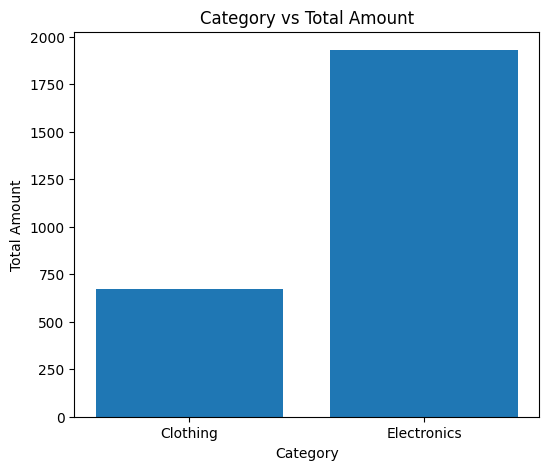

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
pdf = spark.read.format("delta").load(path).toPandas()
agg = pdf.groupby("category", as_index=False)["amount"].sum()
plt.figure(figsize=(6,5))
plt.bar(agg["category"], agg["amount"])
plt.xlabel("Category")
plt.ylabel("Total Amount")
plt.title("Category vs Total Amount")
plt.show()